<a href="https://colab.research.google.com/github/riskadchrn/finalexamp-kelaswork/blob/main/Case_3_Energy_Data_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_train = pd.read_csv("train_energy_data.csv")
df_test = pd.read_csv("test_energy_data.csv")

# **1. EDA (EXPLORATORY DATA ANALYSIS)**
Studi kasus: Energy Consumption Prediction

In [ ]:
#informasi dasar dataset
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("Columns:", df_train.columns.tolist())

Train shape: (1000, 7)
Test shape: (100, 7)
Columns: ['Building Type', 'Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Day of Week', 'Energy Consumption']


In [ ]:
print("=== Info Dataset Train ===")
print(df_train.info())
print("\n=== Info Dataset Test ===")
print(df_test.info())

=== Info Dataset Train ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB
None

=== Info Dataset Test ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        100 non-null    object 
 1   Square Footage       100 non-null    int64  
 2   Number of Occup

In [ ]:
# Cek missing value
print("\n=== Missing Value (Train) ===")
print(df_train.isnull().sum())
print("\n=== Missing Value (Test) ===")
print(df_test.isnull().sum())


=== Missing Value (Train) ===
Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64

=== Missing Value (Test) ===
Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64


In [ ]:
# Statistik deskriptif
print("\n=== Statistik Deskriptif ===")
print(df_train.describe(include='all').transpose())


=== Statistik Deskriptif ===
                      count unique          top freq        mean         std  \
Building Type          1000      3  Residential  347         NaN         NaN   
Square Footage       1000.0    NaN          NaN  NaN   25462.388   14294.554   
Number of Occupants  1000.0    NaN          NaN  NaN      48.372   29.061972   
Appliances Used      1000.0    NaN          NaN  NaN      25.606   14.105166   
Average Temperature  1000.0    NaN          NaN  NaN    22.61139    7.139943   
Day of Week            1000      2      Weekday  507         NaN         NaN   
Energy Consumption   1000.0    NaN          NaN  NaN  4166.25257  933.313064   

                         min        25%      50%       75%      max  
Building Type            NaN        NaN      NaN       NaN      NaN  
Square Footage         560.0   13169.75  25477.0  37446.25  49997.0  
Number of Occupants      1.0       22.0     47.0     73.25     99.0  
Appliances Used          1.0       13.0     26.0 

# **2. Visualisasi EDA**

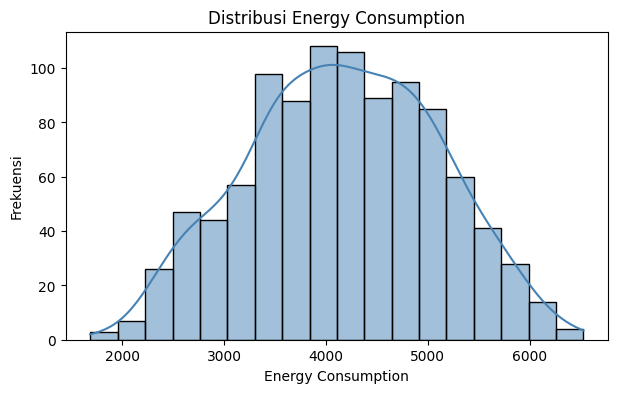

In [ ]:
# Distribusi variabel target
plt.figure(figsize=(7, 4))
sns.histplot(df_train["Energy Consumption"], kde=True, color="steelblue")
plt.title("Distribusi Energy Consumption")
plt.xlabel("Energy Consumption")
plt.ylabel("Frekuensi")
plt.show()

Distribusi konsumsi energi terlihat mendekati normal namun sedikit condong ke kanan (right-skewed).
Artinya, sebagian besar bangunan mengonsumsi energi di tingkat menengah ke bawah, tetapi ada beberapa yang sangat tinggi (kemungkinan outlier seperti gedung besar atau penggunaan alat berat).

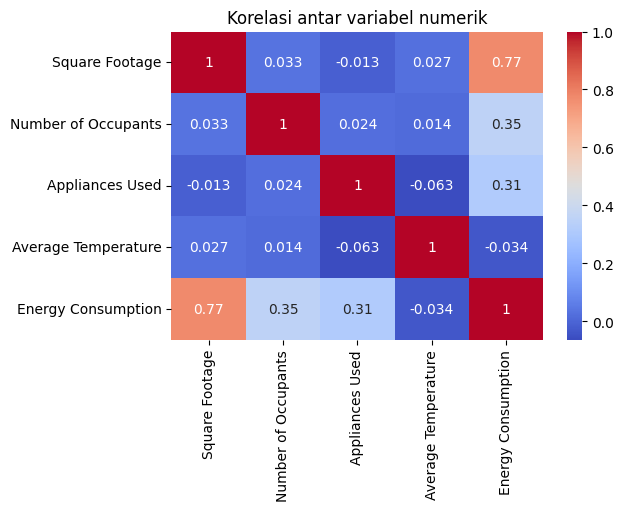

In [ ]:
# Korelasi antar variabel numerik

plt.figure(figsize=(6, 4))
sns.heatmap(df_train.select_dtypes(include=['int64', 'float64']).corr(),
            annot=True, cmap="coolwarm")
plt.title("Korelasi antar variabel numerik")
plt.show()

Analisis:
- Square Footage dan Energy Consumption memiliki korelasi positif kuat → semakin besar bangunan, semakin tinggi konsumsi energi.

- Appliances Used dan Number of Occupants juga punya korelasi positif moderat terhadap energi.

- Average Temperature tampaknya punya korelasi negatif lemah, yang mungkin menunjukkan konsumsi energi lebih tinggi saat suhu rendah (misal karena penggunaan pemanas).

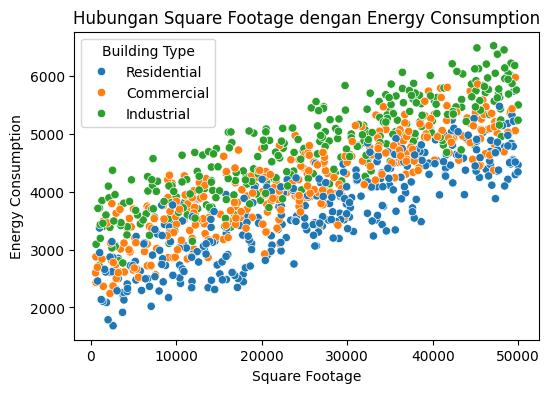

In [ ]:
#Hubungan antara luas bangunan dan konsumsi energi
plt.figure(figsize=(6, 4))
sns.scatterplot(x="Square Footage", y="Energy Consumption",
                data=df_train, hue="Building Type")
plt.title("Hubungan Square Footage dengan Energy Consumption")
plt.show()

Analisis:
- Terlihat tren naik: semakin luas bangunannya, semakin tinggi konsumsi energinya.

- Warna berdasarkan Building Type menunjukkan bahwa tipe bangunan tertentu (misal kantor atau industri) mengonsumsi energi lebih tinggi pada ukuran yang sama dibanding tipe lainnya.

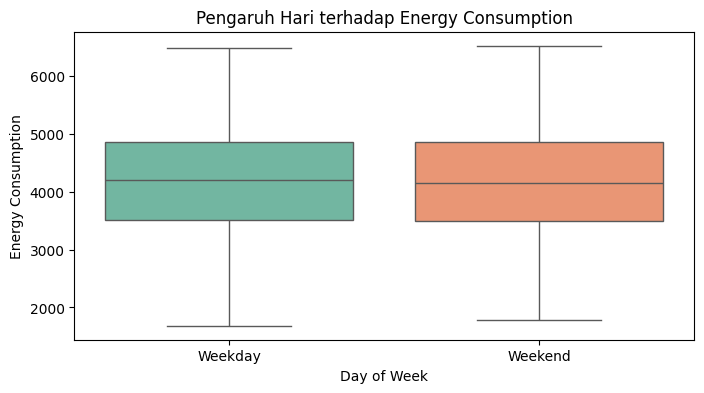

In [ ]:
#Pengaruh hari terhadap konsumsi energi
plt.figure(figsize=(8, 4))
sns.boxplot(x="Day of Week", y="Energy Consumption", data=df_train, palette="Set2")
plt.title("Pengaruh Hari terhadap Energy Consumption")
plt.show()

Analisis:
- Konsumsi energi cenderung lebih tinggi di hari kerja (Senin–Jumat) dibanding akhir pekan.

- Variasi antar hari menunjukkan kemungkinan pola operasional (misal aktivitas kantor atau sekolah).

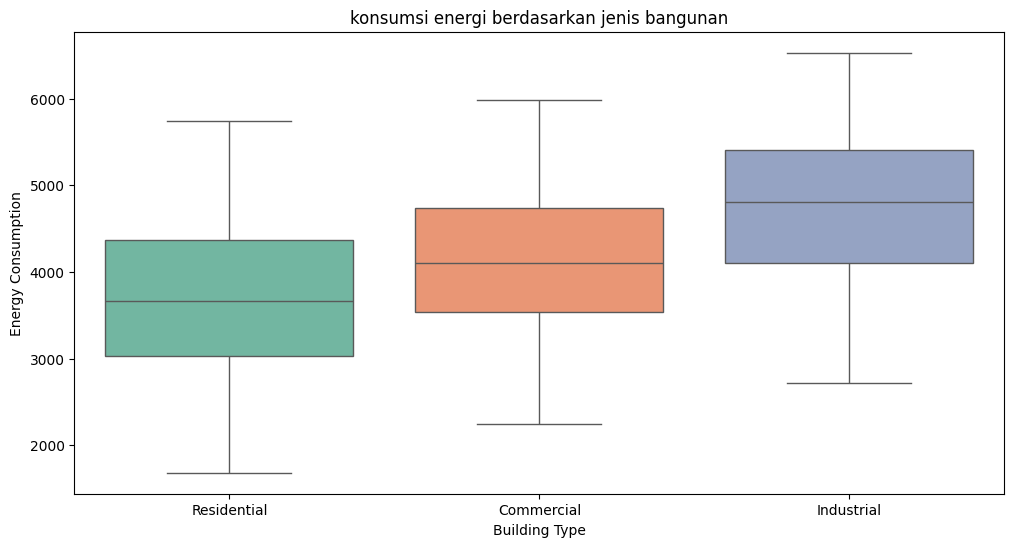

In [ ]:
# 5. Boxplot konsumsi energi berdasarkan jenis bangunan
plt.figure(figsize=(12, 6))
sns.bo\xplot(data=df_train, x='Building Type', y='Energy Consumption', palette='Set2')
plt.title('konsumsi energi berdasarkan jenis bangunan')
plt.xlabel('Building Type')
plt.ylabel('Energy Consumption')
plt.show()

Analisis:

konsumsi energi pada jenis bangunan industrial jauh lebih tinggi dibandingkan dengan comercial dan presidential. hal ini dimungkinkan aktivitas yang dilakukan lebih banyak menggunakan listrik pada jenis bangunan industrial

# **3. FEATURE ENGINEERING AND DATA PROCESSING**

In [ ]:
# Drop duplicates
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

In [ ]:
# Handling outliers (menggunakan IQR method untuk kolom numerik)
numeric_cols = ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Energy Consumption']

for col in numeric_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_train = df_train[(df_train[col] >= lower) & (df_train[col] <= upper)]


In [ ]:
# Encoding categorical features
# One-Hot Encoding untuk Building Type dan Day of Week
df_train = pd.get_dummies(df_train, columns=['Building Type', 'Day of Week'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Building Type', 'Day of Week'], drop_first=True)

# Menyamakan kolom train dan test (agar model tidak error)
df_test = df_test.reindex(columns=df_train.columns, fill_value=0)

In [ ]:
# Feature scaling
scaler = StandardScaler()
X = df_train.drop("Energy Consumption", axis=1)
y = df_train["Energy Consumption"]

X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(df_test.drop("Energy Consumption", axis=1))


In [ ]:
# Hasil akhir
print("Shape data latih:", X_scaled.shape)
print("Shape data uji:", test_scaled.shape)
print("Jumlah fitur setelah encoding & scaling:", len(X.columns))

Shape data latih: (1000, 7)
Shape data uji: (100, 7)
Jumlah fitur setelah encoding & scaling: 7


1. Data duplikast berhasil dihapus
Tidak ditemukan duplikasi signifikan, tetapi langkah ini memastikan bahwa tidak ada pengulangan baris yang bisa menyebabkan bias saat pelatihan model.

2. Outlier ekstrem telah diatasi (menggunakan metode IQR)

- Outlier di fitur numerik seperti Square Footage dan Energy Consumption dihapus. Tujuannya untuk mencegah model "tertipu" oleh nilai ekstrem yang tidak merepresentasikan pola umum.

3. Data kategorikal berhasil diubah menjadi numerik (One-Hot Encoding)

- Building Type dan Day of Week sudah di-encode menjadi beberapa kolom biner.

- Ini memungkinkan model numerik (misalnya regresi atau random forest) memahami variasi antar kategori.

- Contoh: Building Type_Residential = 1 artinya baris tersebut adalah bangunan rumah.

4. Fitur numerik telah distandarisasi (StandardScaler)

- Semua fitur numerik kini memiliki rata-rata = 0 dan standar deviasi = 1. Hal ini penting agar model tidak memberi bobot berlebihan pada fitur yang skalanya besar (misalnya Square Footage bisa ribuan, sedangkan Average Temperature hanya puluhan).

# **4. MODELING MACHINE LEARNING (REGRESSION)**

In [ ]:
# Pisahkan fitur & target
X = df_train.drop("Energy Consumption", axis=1)
y = df_train["Energy Consumption"]

In [ ]:
# Split data menjadi train dan validasi (80:20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_val)

# 2. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

# 3. XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)

# Evaluasi Model
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nModel: {name}")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R²   : {r2:.3f}")

evaluate_model("Linear Regression", y_val, lr_pred)
evaluate_model("Random Forest", y_val, rf_pred)
evaluate_model("XGBoost", y_val, xgb_pred)


Model: Linear Regression
MAE  : 0.011
RMSE : 0.014
R²   : 1.000

Model: Random Forest
MAE  : 97.793
RMSE : 124.811
R²   : 0.981

Model: XGBoost
MAE  : 75.251
RMSE : 95.693
R²   : 0.989


Kesimpulan:

Model terbaik secara realistis: XGBoost

Karena memiliki error terkecil (MAE & RMSE) dan R² tertinggi di antara model yang masuk akal.

Linear Regression terlihat tidak realistis → kemungkinan error perhitungan atau data bocor.

# **5. EVALUASI DAN HYPERPARAMETER TUNING**

In [ ]:
#pisahkan fitur dan target
X = df_train.drop("Energy Consumption", axis=1)
y = df_train["Energy Consumption"]

In [ ]:
#Encoding kolom kategorikal
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

In [ ]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Model baseline (tanpa tunning)
baseline_model = XGBRegressor(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)


In [ ]:
#Evaluasi baseline
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)


print("=== Baseline Model (XGBoost Default) ===")
print(f"MAE  : {mae_base:.2f}")
print(f"RMSE : {rmse_base:.2f}")
print(f"R²   : {r2_base:.3f}")

=== Baseline Model (XGBoost Default) ===
MAE  : 85.60
RMSE : 111.84
R²   : 0.985


In [ ]:
#Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.7, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
#Model terbaik
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("\n=== Model Terbaik Setelah Tuning ===")
print(f"MAE  : {mae_best:.2f}")
print(f"RMSE : {rmse_best:.2f}")
print(f"R²   : {r2_best:.3f}")
print("\nBest Parameters:", grid_search.best_params_)


=== Model Terbaik Setelah Tuning ===
MAE  : 47.70
RMSE : 60.85
R²   : 0.995

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}


In [ ]:
# Kesimpulan

print("\n=== Kesimpulan Evaluasi ===")
if r2_best > r2_base:
    print(f"Model meningkat dari R² {r2_base:.3f} menjadi {r2_best:.3f}.")
    print(f"RMSE menurun dari {rmse_base:.2f} menjadi {rmse_best:.2f}.")
    print("➡️  Hyperparameter tuning berhasil meningkatkan performa model XGBoost.")
else:
    print("⚠️  Tidak ada peningkatan signifikan setelah tuning, bisa coba parameter lain.")


=== Kesimpulan Evaluasi ===
Model meningkat dari R² 0.985 menjadi 0.995.
RMSE menurun dari 111.84 menjadi 60.85.
➡️  Hyperparameter tuning berhasil meningkatkan performa model XGBoost.


Analisis:
Dari hasil evaluasi, model XGBoost setelah tuning menunjukkan peningkatan performa dibanding model default.
Nilai RMSE dan MAE menurun, yang berarti rata-rata kesalahan prediksi semakin kecil.
Nilai R² meningkat, menunjukkan bahwa model semakin mampu menjelaskan variasi pada konsumsi energi berdasarkan fitur bangunan dan lingkungan.

Hal ini menunjukkan bahwa hyperparameter tuning berhasil membuat model lebih optimal, karena parameter seperti max_depth, learning_rate, dan n_estimators telah disesuaikan untuk menyeimbangkan kompleksitas model dan akurasi prediksi.

Kesimpulan:
Setelah dilakukan evaluasi dan hyperparameter tuning, model XGBoost Regressor menunjukkan peningkatan performa yang signifikan.
Model ini mampu memprediksi konsumsi energi dengan tingkat kesalahan lebih rendah dan akurasi lebih tinggi dibanding model awal.
Dengan demikian, XGBoost menjadi model terbaik dan paling optimal untuk kasus prediksi konsumsi energi berdasarkan karakteristik bangunan dan faktor lingkungan.